Aufgabe 1 - Gesamte zugeführte Energie: 469.24 kWh
Aufgabe 2 - Durchschnittlicher Pumpenwirkungsgrad: 71.73 %
Aufgabe 3 - Nicht genutzte Energie: 132.67 kWh


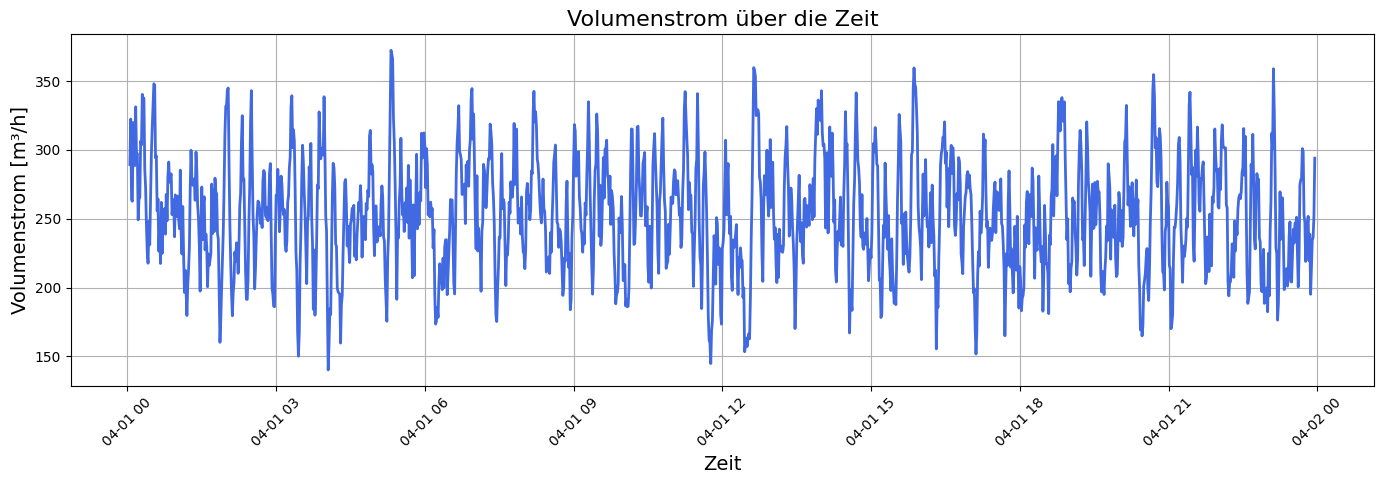

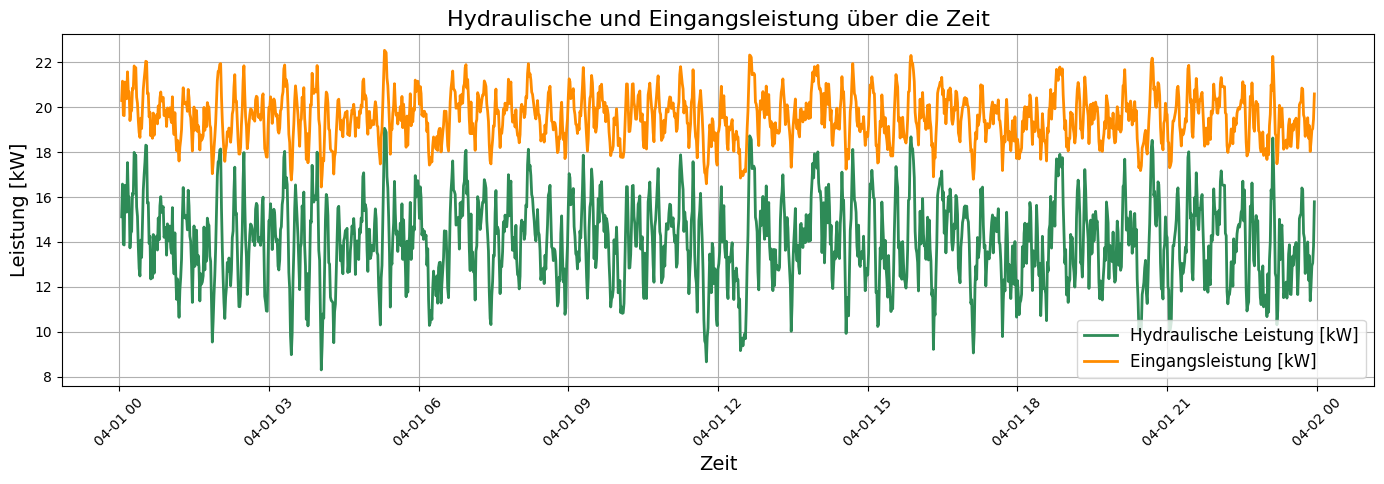

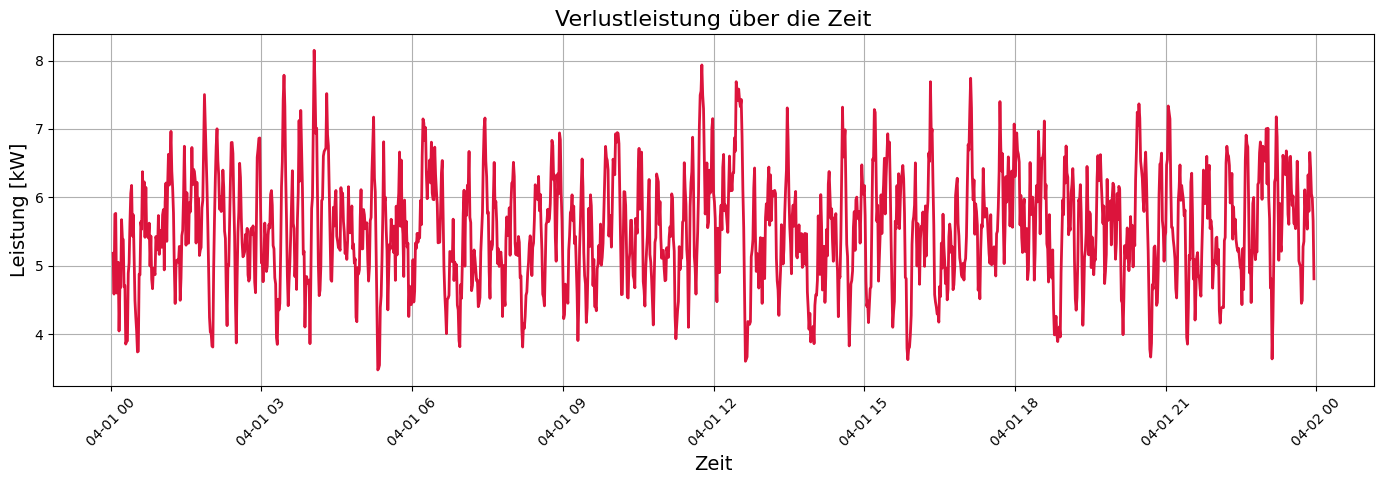

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# -----------------------------------------
# CSV-Datei einlesen und vorbereiten
# -----------------------------------------
url = 'https://raw.githubusercontent.com/SilasBereit/turbomachinery-pumpenanalyse/main/volume_flow_data.csv'

# CSV-Datei mit Header einlesen
df = pd.read_csv(url, sep=',')

# Spalten vereinfachen
df.columns = ['timestamp', 'flow_rate_m3h']

# Timestamp umwandeln
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

# m³/h → m³/s
df['flow_rate_m3s'] = df['flow_rate_m3h'] / 3600

# Zeitdifferenz berechnen (Sekunden)
df['time_delta_s'] = df['timestamp'].diff().dt.total_seconds()
df = df.dropna().reset_index(drop=True)  # erste Zeile ohne Delta t entfernen

# -----------------------------------------
# Förderhöhe interpolieren (Pumpenkennlinie)
# -----------------------------------------
flow_m3h = np.array([110, 240, 300, 350, 425, 495, 555])  # Volumenstrom in m³/h
head_m = np.array([23, 22, 21, 20, 18, 16, 14.3])         # Förderhöhe in m

head_interpolator = interp1d(flow_m3h, head_m, bounds_error=False, fill_value="extrapolate")
df['head_m'] = head_interpolator(df['flow_rate_m3h'])

# Konstanten
rho = 969   # Dichte des Mediums [kg/m³]
g = 9.81    # Erdbeschleunigung [m/s²]

# -----------------------------------------
# Aufgabe 1: Energieverbrauch berechnen
# -----------------------------------------
df['P_hydraulic'] = rho * g * df['flow_rate_m3s'] * df['head_m']  # [W]

# Eingangsleistung laut Datenblatt
flow_for_input_power = np.array([0, 120, 260, 340, 400, 460, 540])  # m³/h
input_power_kW = np.array([12.2, 15.9, 19.9, 22, 23, 24, 25])       # kW
input_power_interpolator = interp1d(flow_for_input_power, input_power_kW, bounds_error=False, fill_value="extrapolate")
df['P_input'] = input_power_interpolator(df['flow_rate_m3h']) * 1000  # [W]

df['E_input'] = df['P_input'] * df['time_delta_s']
total_E_input_kWh = df['E_input'].sum() / 3.6e6

print(f"Aufgabe 1 - Gesamte zugeführte Energie: {total_E_input_kWh:.2f} kWh")

# -----------------------------------------
# Aufgabe 2: Durchschnittlicher Wirkungsgrad
# -----------------------------------------
df['E_hydraulic'] = df['P_hydraulic'] * df['time_delta_s']
total_E_hydraulic_kWh = df['E_hydraulic'].sum() / 3.6e6
pump_efficiency = (total_E_hydraulic_kWh / total_E_input_kWh) * 100

print(f"Aufgabe 2 - Durchschnittlicher Pumpenwirkungsgrad: {pump_efficiency:.2f} %")

# -----------------------------------------
# Aufgabe 3: Verlustleistung bestimmen
# -----------------------------------------
unused_energy_kWh = total_E_input_kWh - total_E_hydraulic_kWh
print(f"Aufgabe 3 - Nicht genutzte Energie: {unused_energy_kWh:.2f} kWh")

# -----------------------------------------
# Aufgabe 4: Visualisierung
# -----------------------------------------

# Zusatzspalten für kW und Verlustleistung
df['P_input_kW'] = df['P_input'] / 1000
df['P_hydraulic_kW'] = df['P_hydraulic'] / 1000
df['Power_Loss_kW'] = df['P_input_kW'] - df['P_hydraulic_kW']

# Gleitender Mittelwert für Glättung (Fenster = 5 Messpunkte)
df_smoothed = df[['timestamp', 'flow_rate_m3h', 'P_hydraulic_kW', 'P_input_kW', 'Power_Loss_kW']].copy()
df_smoothed[['flow_rate_m3h', 'P_hydraulic_kW', 'P_input_kW', 'Power_Loss_kW']] = df_smoothed[['flow_rate_m3h', 'P_hydraulic_kW', 'P_input_kW', 'Power_Loss_kW']].rolling(window=5, center=True).mean()

# Allgemeine Plot-Einstellungen
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

# Plot 1: Volumenstrom
plt.figure(figsize=(14, 5))
plt.plot(df_smoothed['timestamp'], df_smoothed['flow_rate_m3h'], color='royalblue', linewidth=2)
plt.title('Volumenstrom über die Zeit')
plt.xlabel('Zeit')
plt.ylabel('Volumenstrom [m³/h]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Hydraulische Leistung vs. Eingangsleistung
plt.figure(figsize=(14, 5))
plt.plot(df_smoothed['timestamp'], df_smoothed['P_hydraulic_kW'], label='Hydraulische Leistung [kW]', color='seagreen', linewidth=2)
plt.plot(df_smoothed['timestamp'], df_smoothed['P_input_kW'], label='Eingangsleistung [kW]', color='darkorange', linewidth=2)
plt.title('Hydraulische und Eingangsleistung über die Zeit')
plt.xlabel('Zeit')
plt.ylabel('Leistung [kW]')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Verlustleistung
plt.figure(figsize=(14, 5))
plt.plot(df_smoothed['timestamp'], df_smoothed['Power_Loss_kW'], color='crimson', linewidth=2)
plt.title('Verlustleistung über die Zeit')
plt.xlabel('Zeit')
plt.ylabel('Leistung [kW]')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
